In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

In [2]:
def load_json(filename):
    with open(filename) as f:
        annotation = json.load(f)
    return annotation

def load_segmentation_dataset(f_p,label_names=None):
    """"
    Returns:
        [dict]: Dictionary of list with names 
    """
    data=load_json(f_p)
    cat_map={}
    for cat in data["categories"]:
        if cat["name"] in label_names:
            cat_map[cat['id']]=cat["name"] 
    image_map={}
    for cat in data["images"]:
        image_map[cat['id']]=cat["file_name"] 
    annos={}
    for d in data["annotations"]:
        tmp=[]
        seg=d["segmentation"][0]
        for i in range(0,len(seg)-1,2):
            tmp.append([seg[i],seg[i+1]]) 
        if image_map[d["image_id"]] not in annos:
            annos[image_map[d["image_id"]]]=[{"class_id":cat_map[d["category_id"]],"annotation":tmp}]
        else:
            annos[image_map[d["image_id"]]].append({"class_id":cat_map[d["category_id"]],"annotation":tmp})
    return annos

In [3]:
data_dir="/home/asad/projs/SMN/data/cucumber"
json_name="labels_my-project-name_2021-12-17-03-00-40.json"
classes=["color_board","cucumber","backbone"] 
ann=load_segmentation_dataset(os.path.join(data_dir,json_name),classes)

In [4]:
len(ann['P00000000879558637815805_1076_  _032621132951.jpg'])

11

In [5]:
for item in ann['P00000000879558637815805_1076_  _032621132951.jpg']:
    print(item.keys())

dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])
dict_keys(['class_id', 'annotation'])


In [6]:
len(ann)

2

In [7]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_veg_dicts(data_dir): 
    
    dataset_dicts = []
    for idx,k in enumerate(ann.keys()):
        c_fname = os.path.join(data_dir, k)
        img = cv2.imread(c_fname)
        if img is None:
            raise("Some thing is wrong image is None")
        record = {}
        height, width = img.shape[:2]
        record["file_name"] = c_fname
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        annos = ann[k]
        objs = []
        
        for anno in annos:
            if (anno["class_id"]!="color_board" and anno["class_id"]!="cucumber"):
                continue
            if (anno["class_id"]=="color_board"):
                catid=0
            if (anno["class_id"]=="cucumber"):
                catid=1
            px = [x for x, y in anno['annotation']]
            py = [y for x, y in anno['annotation']]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": catid,
            }
            objs.append(obj)
        record["annotations"] = objs
        #print(f"Processed images {idx}")
        dataset_dicts.append(record)
    

    return dataset_dicts

#for d in ["train", "val"]:
#    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
#balloon_metadata = MetadataCatalog.get("balloon_train")

In [8]:
for d in ["train", "val"]:
    DatasetCatalog.register("cucumber_" + d, lambda d=d: get_veg_dicts(data_dir))
    MetadataCatalog.get("cucumber_" + d).set(thing_classes=["color_board","cucumber"])


In [9]:
cucumber_metadata = MetadataCatalog.get("cucumber_train")

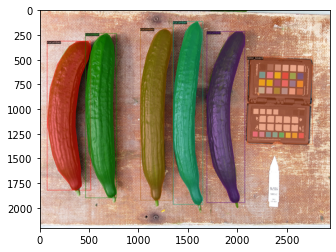

In [12]:
dataset_dicts = get_veg_dicts(data_dir)
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cucumber_metadata, scale=0.9)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    cv2.imwrite("test.png",out.get_image()[:, :, ::-1])
    #cv2.imshow(out.get_image()[:, :, ::-1])

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cucumber_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.ROI_MASK_HEAD.NUM_DECONV=1
cfg["INPUT"]["ROTATE"] = [0, 0]
cfg["INPUT"]["LIGHT_SCALE"] = 1.1
cfg["INPUT"]["Brightness_SCALE"] = [1, 1]
cfg["INPUT"]["Contrast_SCALE"] = [1, 1]
cfg["INPUT"]["Saturation_SCALE"] = [1, 1]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/16 13:55:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/16 13:55:14 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[05/16 13:55:14 d2.data.build]: Distribution of instances among all 2 categories:
|  category   | #instances   |  category  | #instances   |
|:-----------:|:-------------|:----------:|:-------------|
| color_board | 2            |  cucumber  | 14           |
|             |              |            |              |
|    total    | 16           |            |              |
[05/16 13:55:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[0, 0]), RandomLighting(scale=1.1), RandomSaturation(intensity_min=1, intensity_max=1), RandomBrightness(intensity_min=1, intensity_max=1), RandomContrast(intensity_min=1, intensity_max=1)]
[05/16 13:55:14 d2.data.build]: Using training sampler TrainingSampler
[05/16 13:55:14 d2.data.common]: Seri

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[05/16 13:55:16 d2.engine.train_loop]: Starting training from iteration 0


/home/asad/anaconda/envs/detfastai/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448233824/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/asad/anaconda/envs/detfastai/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448233824/work/c10/core/TensorImpl.h:1156.)
  return 

[05/16 13:55:27 d2.utils.events]:  eta: 0:08:25  iter: 19  total_loss: 2.702  loss_cls: 0.9979  loss_box_reg: 0.9084  loss_mask: 0.692  loss_rpn_cls: 0.01862  loss_rpn_loc: 0.07638  time: 0.5355  data_time: 0.3420  lr: 4.9953e-06  max_mem: 2345M
[05/16 13:55:37 d2.utils.events]:  eta: 0:08:19  iter: 39  total_loss: 2.582  loss_cls: 0.9368  loss_box_reg: 0.864  loss_mask: 0.6894  loss_rpn_cls: 0.01808  loss_rpn_loc: 0.07121  time: 0.5350  data_time: 0.3472  lr: 9.9902e-06  max_mem: 2345M
[05/16 13:55:48 d2.utils.events]:  eta: 0:08:09  iter: 59  total_loss: 2.44  loss_cls: 0.8304  loss_box_reg: 0.8363  loss_mask: 0.6832  loss_rpn_cls: 0.01022  loss_rpn_loc: 0.06389  time: 0.5311  data_time: 0.3332  lr: 1.4985e-05  max_mem: 2345M
[05/16 13:55:58 d2.utils.events]:  eta: 0:07:57  iter: 79  total_loss: 2.298  loss_cls: 0.7044  loss_box_reg: 0.8597  loss_mask: 0.6751  loss_rpn_cls: 0.009266  loss_rpn_loc: 0.05683  time: 0.5274  data_time: 0.3274  lr: 1.998e-05  max_mem: 2345M
[05/16 13:56:09

[05/16 14:00:54 d2.utils.events]:  eta: 0:02:49  iter: 659  total_loss: 0.3093  loss_cls: 0.03939  loss_box_reg: 0.08758  loss_mask: 0.1605  loss_rpn_cls: 0.0001582  loss_rpn_loc: 0.02279  time: 0.5082  data_time: 0.2986  lr: 0.00016484  max_mem: 2345M
[05/16 14:01:03 d2.utils.events]:  eta: 0:02:39  iter: 679  total_loss: 0.3038  loss_cls: 0.04231  loss_box_reg: 0.08392  loss_mask: 0.1502  loss_rpn_cls: 0.0001123  loss_rpn_loc: 0.02706  time: 0.5067  data_time: 0.2847  lr: 0.00016983  max_mem: 2345M
[05/16 14:01:12 d2.utils.events]:  eta: 0:02:28  iter: 699  total_loss: 0.2757  loss_cls: 0.03815  loss_box_reg: 0.07346  loss_mask: 0.1392  loss_rpn_cls: 9.153e-05  loss_rpn_loc: 0.02399  time: 0.5050  data_time: 0.2674  lr: 0.00017483  max_mem: 2345M
[05/16 14:01:22 d2.utils.events]:  eta: 0:02:18  iter: 719  total_loss: 0.2666  loss_cls: 0.03785  loss_box_reg: 0.07241  loss_mask: 0.1319  loss_rpn_cls: 0.0001503  loss_rpn_loc: 0.02203  time: 0.5038  data_time: 0.2953  lr: 0.00017982  max

In [14]:
## predictions

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.99   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [18]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_veg_dicts(data_dir)
for i,d in enumerate(dataset_dicts):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=cucumber_metadata, 
                   scale=0.9, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    cv2.imwrite(f"{i}.png",out.get_image()[:, :, ::-1])
    #cv2_imshow(out.get_image()[:, :, ::-1])